# Économétrie pure

On veut valider empiriquement l'équation suivante : 
$$\phi_{t}^{i} = \frac{1}{c_{\phi}^{i}}(P^{i}-A^{i}(E_{t}^{i}-\Psi_{t}^{i}))$$
Avec : 
- $\phi_{t}^{i}$: Flux mensuel de communication environnementale au mois $t$ pour l'entreprise $i$.
- $c_{t}^{i}$: Coût marginal de communication.
- $E_{t}^{i}$: Score environnemental au mois $t$ pour l'entreprise $i$.
- $\Psi_{t}^{i}$: Valeur environnementale fondamentale de l'entreprise $i$ au mois $t$.


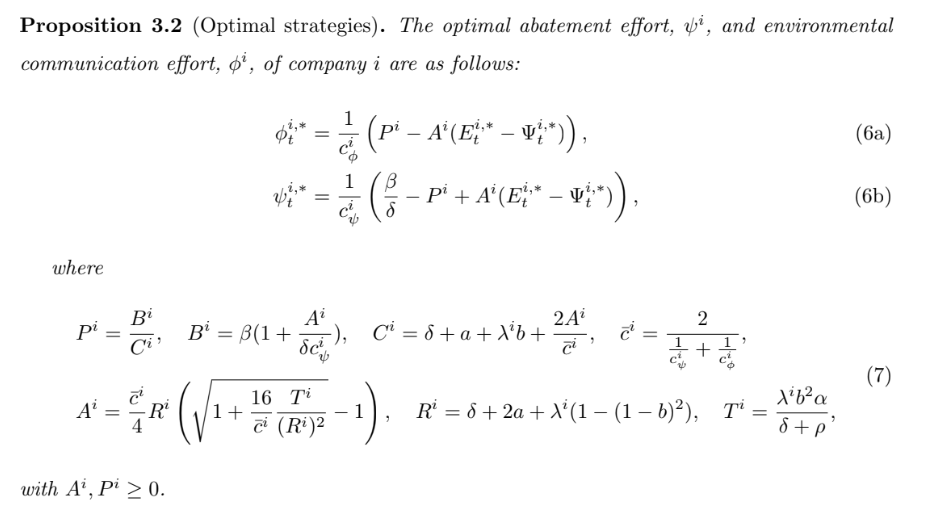

## 1st step

On cherche à construire un proxy $\hat{\phi}^{i}_{t}$ pour $\phi^{i}_{t}$. 


Nous construisons un score de communication environnementale, $\hat{\varepsilon}^{i}_{1,t}$, purifié de l'effet des controverses environnementales, défini comme les résidus de la régression Within de $Rep^{i}_{t}$ sur $Con^{i}_{t}$ avec des effets fixes dans le temps et pour l'entreprise, où $Con^{i}_{t}$ est instrumenté par $Con^{i}_{t-1}$ :
\begin{equation}
Rep^{i}_{t} = \alpha^{i}_{1,1} + \alpha_{1,2,t} + \beta_1 Con^{i,*}_{t} + \varepsilon^{i}_{1,t}
\end{equation}

où $Con^{i,*}_{t} = \hat{\beta}_2 Con^{i}_{t-1}$ est la prédiction de la régression suivante :
\begin{equation}
Con^{i}_{t} = \alpha^{i}_{2,1} + \alpha_{2,2,t} + \beta_2 Con^{i}_{t-1} + \varepsilon^{i}_{2,t}.
\end{equation}

--------------- TESTER PERTINENCE DE L'INSTRUMENT ----------------

Le test de pertinence de l'instrument $Con^{i}_{t}$ donne un $R^2$ de la régression de $Con^{i}_{t}$ sur $Con^{i}_{t-1}$ de 78,3\%. De plus, la condition d'exogénéité faible est satisfaite, assurant que les résidus de la régression 2SLS peuvent être utilisés pour construire un proxy du score de communication environnementale. Nous définissons alors un proxy du flux de communication environnementale, $\hat{\varphi}^{i}_{t}$, comme la première différence du score de communication environnementale :
\begin{equation}
\hat{\varphi}^{i}_{t} \equiv \hat{\varepsilon}^{i}_{1,t} - \hat{\varepsilon}^{i}_{1,t-1}.
\end{equation}

Ce proxy représente le flux de communication environnementale de l'entreprise i au mois t.

In [ ]:
from linearmodels.panel import PanelOLS, FirstDifferenceOLS
from linearmodels.iv import IV2SLS
from linearmodels.panel import PanelData

# Préparation des données
# Supposons que 'df' est notre DataFrame avec ['id_entreprise', 'temps', 'Rep', 'Con']
df = df.set_index(['id_entreprise', 'temps'])
df['Con_lag'] = df.groupby(level=0)['Con'].shift(1)

# Première étape: Régression de Con sur Con_lag avec effets fixes
# Pour les effets fixes dans linearmodels, on utilise directement PanelOLS
first_stage = PanelOLS.from_formula('Con ~ 1 + Con_lag + EntityEffects + TimeEffects', data=df)
res_first_stage = first_stage.fit()
df['Con_star'] = res_first_stage.fitted_values

# Deuxième étape: Régression 2SLS de Rep sur Con instrumenté par Con_star avec effets fixes
instrumented_variable = df['Con_star']
dependent_variable = df['Rep']
exogenous_variables = pd.DataFrame({'const': 1})  # Ajouter d'autres variables exogènes si nécessaire
exogenous_variables.index = df.index

second_stage = IV2SLS(dependent_variable, exogenous_variables, instrumented_variable, None).fit()
df['epsilon_hat'] = second_stage.resids

# Calcul du proxy du flux de communication environnementale
df['phi_hat'] = df.groupby(level=0)['epsilon_hat'].diff()


# Le reste du code

In [ ]:
def get_user_date(start_date, end_date):
    # Prompt the user for a date
    user_date_str = input(f"Enter a date between {start_date} and {end_date} (format YYYY-MM): ")
    
    # Convert user input to a pandas Timestamp
    try:
        user_date = pd.to_datetime(user_date_str, format='%Y-%m')
        start_date = pd.to_datetime(start_date, format='%Y-%m')
        end_date = pd.to_datetime(end_date, format='%Y-%m')

        # Check if the date is within the range
        if start_date <= user_date <= end_date:
            print(f"Selected date: {user_date.strftime('%Y-%m')}")
            return user_date
        else:
            print("Date is out of range. Please try again.")
            return None
    except ValueError:
        print("Invalid date format. Please try again.")
        return None

# Example usage
get_user_date("2002-01", "2023-04")


In [ ]:
# On laisse l'utilisateur choisir une date
date_debut="2002-01"
date_fin="2023-04"
t = get_user_date(date_debut,date_fin)
t = pd.to_datetime(t, format='%Y-%m')
t_minus_1 = (t - pd.DateOffset(months=1)).strftime('%Y-%m')
print(t_minus_1)

# On recupère les scores des etp aux dates t et t-1
col_index = esg_data.columns.get_loc(t)
esge_t = esg_data.iloc[:, col_index]
col_index = esg_data.columns.get_loc(t_minus_1)
esge_t_minus_1 = esg_data.iloc[:, col_index]

In [ ]:
data = {
    'env_comm_score': env_comm_score, 
    'esge': esge_t
    'esge_past': esge_t_minus_1
    'esge_peer': np.random.uniform(0, 100, 100)  # 100 peer environmental scores in the same sector
}

df = pd.DataFrame(data)

# Show the first few rows of the DataFrame
print(df.head())

# Define your variables
dependent = df['env_comm_score']
independent = df[['const']]  # Assuming you've added a constant term to your DataFrame
instrument = df['esge_past']  # Instrumenting esge with its past value
endogenous = df['esge']  # The variable you believe is endogenous

# Setup and run the 2SLS regression
model = IV2SLS(dependent, independent, endogenous, instrument).fit()

# Print model summary
print(model.summary)

# To instrument 'esge' with both its past value and peer scores, you might do:
instrument2 = df[['esge_past', 'esge_peer']]
model2 = IV2SLS(dependent, independent, endogenous, instrument2).fit()
print(model2.summary)
